In [1]:
import gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

from itertools import count
from collections import namedtuple

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer of Transition 

In [4]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        if len(self.memory) == self.capacity:
            self.memory.pop()
        
        self.memory.insert(0, Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) # a list of element from self.memory
    
    def __len__(self):
        return len(self.memory)

# Critic - Q Function

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        '''
        2 Hidden layers
        400 & 300 units each
        action is only introduced in 2nd hidden layer
        '''
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)
        
    def forward(self, state, action):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(torch.cat([x, action], dim=1)))
        x = self.l3(x)
        return x

# Actor - Policy

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, sup_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.sup_action = sup_action  # suppermum of action space
    
    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = self.sup_action * torch.tanh(self.l3(x))
        return x

# DDPG (mainly everything)

In [7]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, sup_action, memory_capacity, batch_size, 
                 gamma=0.99, critic_lr=1e-2, actor_lr=1e-4, polyak=0.999):
        # critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), weight_decay=1e-2)
        
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # actor
        self.actor = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.actor_target = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # replay buffer
        self.replay_buffer = ReplayBuffer(memory_capacity)
        # hyper parameters
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.polyak = polyak
    
    def train(self, iteration):
        avg_critic_loss = 0
        avg_actor_loss = 0
        for i in range(iteration):
            # sample exp from replay buffer
            transitions = self.replay_buffer.sample(self.BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            # pull out index (i.e. mask) in the batch & next_state of transitions having next_state is not None
            mask_nonFinal_next_states = torch.tensor(tuple(map(lambda s: s is not None, 
                                                              batch.next_state)), device=device, dtype=torch.uint8)
            nonFinal_next_states = torch.cat([s for s in batch.next_state
                                                 if s is not None])
            # construct tensor of state, action, reward
            states_batch = torch.cat(batch.state)
            actions_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # compute TD target
            next_state_act_val = torch.zeros([self.BATCH_SIZE, 1], device=device)
    #         print(self.actor_target(nonFinal_next_states))
    #         print("nonFinal_next_states:\n", nonFinal_next_states)
    #         print("critic output:\n",self.critic_target(nonFinal_next_states, 
    #                                                                         self.actor_target(nonFinal_next_states)))
    #         print("mask_nonFinal_next_states:\n", mask_nonFinal_next_states)
            next_state_act_val[mask_nonFinal_next_states] = self.critic_target(nonFinal_next_states, 
                                                                            self.actor_target(nonFinal_next_states))
            td_target = reward_batch + self.GAMMA * next_state_act_val.detach()

            critic_loss = F.mse_loss(self.critic(states_batch, actions_batch), td_target)  # MS of td_error
            avg_critic_loss += critic_loss.item()
            
            # call optimizer of critic to minimize loss
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # Update actor
            actor_loss = -self.critic(states_batch, self.actor(states_batch)).mean() 
            avg_actor_loss += actor_loss.item()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update target actor & target critic
            with torch.no_grad():
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)
            
            return avg_critic_loss/iteration, avg_actor_loss/iteration
    
    def select_action(self, state):
#         state = torch.FloatTensor(state.reshape(1, -1)).to(device)
#         return self.actor(state).cpu().data.numpy().flatten()
        return self.actor(state)


# Utilities

In [16]:
def to_tensor(np_array):
    '''
    convert 1d np array to tensor (written as a row vector)
    '''
    return torch.FloatTensor(np_array.reshape(1, -1)).to(device)

def checkout_actor(render=False):
    state = env.reset()
    state = to_tensor(state)
    accu_reward = 0
    for step in count():
        action = agent.actor(state).detach()
        
        _act = action.cpu()
        next_state, reward, done, _ = env.step(_act.data.numpy().flatten())
        accu_reward += reward
        next_state = to_tensor(next_state)
        
        if render:
            env.render()
        if done:
            print("Episode %d [ACTOR] Finish after %d step\tAccumulated reward:%.3f" % (i_episode, step+1, accu_reward))
            print("-------------------------------------")
            break
        # Move on 
        state.data.copy_(next_state.data)
    return accu_reward

# checkout_actor()
# time.sleep(1)
# env.close()

# Training

In [72]:
env = gym.make("LunarLanderContinuous-v2")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
sup_action = torch.Tensor(env.action_space.high).to(device)

memory_capacity = 3000
batch_size = 64

agent = DDPG(state_dim, action_dim, sup_action, memory_capacity, batch_size)

actor_accumulated_reward = []

In [75]:
max_episode = 501
max_random_action_steps = 1000
random_action_steps = 0

flag_collecting_exp = 0

std_dev = 0.25 * np.max(env.action_space.high - env.action_space.low)

for i_episode in range(max_episode):
    state = env.reset()
    state = to_tensor(state)
    for step in count():
        # Choose action
        if random_action_steps < max_random_action_steps:
            action = to_tensor(env.action_space.sample())
            random_action_steps += 1
        else:
            action = agent.select_action(state)    
        
        # take action & observe next state & reward
        _act = action.cpu().data.numpy().flatten()
        _act = np.random.normal(_act, 0.075).clip(env.action_space.low, env.action_space.high)
                                                                                             
        next_state, reward, done, _ = env.step(_act)
        next_state = to_tensor(next_state)
        reward = to_tensor(np.array([reward]))
        
        # update replay buffer
        action = to_tensor(_act)
        agent.replay_buffer.push(state, action, next_state, reward)
        
        # check if replay_buffer is enough for update
        if agent.replay_buffer.__len__() < max_random_action_steps:
            if flag_collecting_exp == 0:
                flag_collecting_exp = 1
                print("Collecting experience ...")
            continue
        
        if flag_collecting_exp == 1:
            flag_collecting_exp = 2
            print("Done collecting exp >>> Enter training process")
        
        # if enough experiences for update
        avg_critic_loss, avg_actor_loss = agent.train(iteration=5)
#         if step % 100 == 0:
#             print("Episode %d \t critic loss: %.3f \t actor loss:%.3f" % (i_episode, avg_critic_loss, 
#                                                                           avg_actor_loss))
        
        if done:
            _rew = reward.cpu()
            print("Episode %d finish with reward = %.2f" % (i_episode, _rew.data.numpy().flatten()))
            print("------------------------------------------------")
            break
        
        # move on
        state.data.copy_(next_state.data)
    
    if i_episode % 10 == 0:
        actor_accumulated_reward.append(checkout_actor())
        

Episode 0 finish with reward = -100.00
------------------------------------------------
Episode 0 [ACTOR] Finish after 84 step	Accumulated reward:-422.071
-------------------------------------
Episode 1 finish with reward = -100.00
------------------------------------------------
Episode 2 finish with reward = -100.00
------------------------------------------------
Episode 3 finish with reward = -100.00
------------------------------------------------
Episode 4 finish with reward = -100.00
------------------------------------------------
Episode 5 finish with reward = -100.00
------------------------------------------------
Episode 6 finish with reward = -100.00
------------------------------------------------
Episode 7 finish with reward = -100.00
------------------------------------------------
Episode 8 finish with reward = -100.00
------------------------------------------------
Episode 9 finish with reward = -100.00
------------------------------------------------
Episode 10 fini

Episode 82 finish with reward = -100.00
------------------------------------------------
Episode 83 finish with reward = -100.00
------------------------------------------------
Episode 84 finish with reward = -100.00
------------------------------------------------
Episode 85 finish with reward = -100.00
------------------------------------------------
Episode 86 finish with reward = -100.00
------------------------------------------------
Episode 87 finish with reward = -100.00
------------------------------------------------
Episode 88 finish with reward = -100.00
------------------------------------------------
Episode 89 finish with reward = -100.00
------------------------------------------------
Episode 90 finish with reward = -100.00
------------------------------------------------
Episode 90 [ACTOR] Finish after 62 step	Accumulated reward:-605.474
-------------------------------------
Episode 91 finish with reward = -100.00
------------------------------------------------
Epis

Episode 164 finish with reward = -100.00
------------------------------------------------
Episode 165 finish with reward = -100.00
------------------------------------------------
Episode 166 finish with reward = -100.00
------------------------------------------------
Episode 167 finish with reward = -100.00
------------------------------------------------
Episode 168 finish with reward = -100.00
------------------------------------------------
Episode 169 finish with reward = -100.00
------------------------------------------------
Episode 170 finish with reward = -100.00
------------------------------------------------
Episode 170 [ACTOR] Finish after 146 step	Accumulated reward:-2202.190
-------------------------------------
Episode 171 finish with reward = -100.00
------------------------------------------------
Episode 172 finish with reward = -100.00
------------------------------------------------
Episode 173 finish with reward = -100.00
----------------------------------------

Episode 246 finish with reward = -100.00
------------------------------------------------
Episode 247 finish with reward = -100.00
------------------------------------------------
Episode 248 finish with reward = -100.00
------------------------------------------------
Episode 249 finish with reward = -100.00
------------------------------------------------
Episode 250 finish with reward = -100.00
------------------------------------------------
Episode 250 [ACTOR] Finish after 52 step	Accumulated reward:-441.538
-------------------------------------
Episode 251 finish with reward = -100.00
------------------------------------------------
Episode 252 finish with reward = -100.00
------------------------------------------------
Episode 253 finish with reward = -100.00
------------------------------------------------
Episode 254 finish with reward = -100.00
------------------------------------------------
Episode 255 finish with reward = -100.00
------------------------------------------

Episode 328 finish with reward = -100.00
------------------------------------------------
Episode 329 finish with reward = -100.00
------------------------------------------------
Episode 330 finish with reward = -100.00
------------------------------------------------
Episode 330 [ACTOR] Finish after 73 step	Accumulated reward:-452.685
-------------------------------------
Episode 331 finish with reward = -100.00
------------------------------------------------
Episode 332 finish with reward = -100.00
------------------------------------------------
Episode 333 finish with reward = -100.00
------------------------------------------------
Episode 334 finish with reward = -100.00
------------------------------------------------
Episode 335 finish with reward = -100.00
------------------------------------------------
Episode 336 finish with reward = -100.00
------------------------------------------------
Episode 337 finish with reward = -100.00
------------------------------------------

Episode 410 finish with reward = -100.00
------------------------------------------------
Episode 410 [ACTOR] Finish after 83 step	Accumulated reward:-838.786
-------------------------------------
Episode 411 finish with reward = -100.00
------------------------------------------------
Episode 412 finish with reward = -100.00
------------------------------------------------
Episode 413 finish with reward = -100.00
------------------------------------------------
Episode 414 finish with reward = -100.00
------------------------------------------------
Episode 415 finish with reward = -100.00
------------------------------------------------
Episode 416 finish with reward = -100.00
------------------------------------------------
Episode 417 finish with reward = -100.00
------------------------------------------------
Episode 418 finish with reward = -100.00
------------------------------------------------
Episode 419 finish with reward = -100.00
------------------------------------------

Episode 491 finish with reward = -100.00
------------------------------------------------
Episode 492 finish with reward = -100.00
------------------------------------------------
Episode 493 finish with reward = -100.00
------------------------------------------------
Episode 494 finish with reward = -100.00
------------------------------------------------
Episode 495 finish with reward = -100.00
------------------------------------------------
Episode 496 finish with reward = -100.00
------------------------------------------------
Episode 497 finish with reward = -100.00
------------------------------------------------
Episode 498 finish with reward = -100.00
------------------------------------------------
Episode 499 finish with reward = -100.00
------------------------------------------------
Episode 500 finish with reward = -100.00
------------------------------------------------
Episode 500 [ACTOR] Finish after 61 step	Accumulated reward:-495.643
-------------------------------

In [80]:
checkout_actor(True)

time.sleep(1)
env.close()

Episode 500 [ACTOR] Finish after 59 step	Accumulated reward:-469.560
-------------------------------------


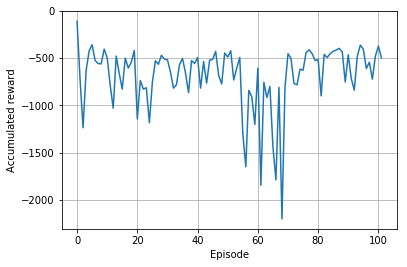

In [76]:
plt.figure(1)
plt.plot(actor_accumulated_reward)
plt.ylabel("Accumulated reward")
plt.xlabel("Episode")
plt.grid()
plt.show()

In [61]:
torch.save(agent.actor.state_dict(), 'lunarlander_ddpg_actor.pth')
torch.save(agent.critic.state_dict(), 'lunarlander_ddpg_critic.pth')

In [38]:
std_dev = 0.25 * np.max(env.action_space.high - env.action_space.low)

In [39]:
std_dev

0.5

In [2]:
a = np.array([-1, 0, 2])
low = np.array([0, 0, 0])
high = np.array([1, 1, 1])
print(a.clip(low, high))

[0 0 1]


In [3]:
np.random.normal(a, 0.5)

array([-1.0753723 , -0.21484857,  2.28415667])